# Movie Recommender System

In this notebook we'll be building a Movie Recommendation System using the preprocessed dataset which was pre processed in the previous notebook, we will pretty much build as a foundation in recommendation systems and will provide you with something to start with.

* [Simple Recommender](#simple_rec)
* [Content Based Recommender](#cont_base)
* [Collaborative Filtering](#collab_fil)
* [Hybrid Recommender](#hyb_reco)
* [Conclusion](#conc)

<a class='anchor' id="simple_rec"></a>

## Simple Recommender

* The Simple Recommender provides universal movie recommendations to all users, relying on factors such as overall popularity and, occasionally, genre. The fundamental concept behind this recommender is that films with higher popularity and critical acclaim are more likely to be enjoyed by the average audience. Unlike personalized recommendation models, this approach does not tailor suggestions to individual users.

* Implementing this model is straightforward—sorting movies based on ratings and popularity, then presenting the top-ranked movies. Optionally, the model can also consider a genre parameter to filter and display the top movies within a specific genre.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import requests
from IPython.display import Image, display
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import time

import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd. read_csv('engineered_data.csv')
md=df
df.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count',
       'cast', 'return', 'year', 'cast_size', 'crew_size', 'director',
       'is_Animation', 'is_Comedy', 'is_Family', 'is_Adventure', 'is_Fantasy',
       'is_Romance', 'is_Drama', 'is_Action', 'is_Crime', 'is_Thriller',
       'is_Horror', 'is_History', 'is_Science Fiction', 'is_Mystery', 'is_War',
       'is_Foreign', 'is_Music', 'is_Documentary', 'is_Western', 'is_TV Movie',
       'is_english', 'is_Friday', 'is_Holiday'],
      dtype='object')


Weighted Rating (WR) = (v/v + m) * R + (m/v + m) * C

where,

v is the number of votes for the movie
m is the minimum votes required for chart inclusion
R is the average rating of the movie
C is the mean vote across the entire dataset

The next step involves determining a suitable value for m, the minimum votes needed for chart inclusion. The 95th percentile is chosen as the cutoff, meaning a movie must have more votes than at least 95% of the movies in the list to feature in the charts.

The process begins with constructing the overall Top 250 Chart, followed by the creation of a function to build charts for specific genres. Let's get started!

In [3]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.24516242394957

In [4]:
m = vote_counts.quantile(0.95)
m

433.0

In [5]:
#md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [6]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & 
               (md['vote_average'].notnull())][['title','overview', 'release_date', 
                                                'vote_count', 'vote_average', 'popularity', 'genres']]

qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
print(qualified.shape)

(2282, 7)


Therefore, to qualify to be considered for the chart, a movie has to have at least 433 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.245 on a scale of 10. 

overall 2282 Movies qualify to be on our chart.

In [7]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

In [8]:
qualified['wr'] = qualified.apply(weighted_rating, m=m, C=C, axis=1)

In [9]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

### Top Movies

In [10]:
qualified.head(10)

,title,overview,release_date,vote_count,vote_average,popularity,genres,wr
15545,Inception,"Cobb, a skilled thief who commits corporate es...",2010-07-14,14075,8,29.108149,5,7.917780
12525,The Dark Knight,Batman raises the stakes in his war on crime. ...,2008-07-16,12269,8,123.167259,4,7.906090
22949,Interstellar,Interstellar chronicles the adventures of a gr...,2014-11-05,11187,8,32.213481,3,7.897346
2854,Fight Club,A ticking-time-bomb insomniac and a slippery s...,1999-10-15,9678,8,63.869599,1,7.882025
4880,The Lord of the Rings: The Fellowship of the Ring,"Young hobbit Frodo Baggins, after inheriting a...",2001-12-18,8892,8,32.070725,3,7.872081
292,Pulp Fiction,"A burger-loving hit man, his philosophical par...",1994-09-10,8670,8,140.950236,2,7.868961
314,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,1994-09-23,8358,8,51.645403,2,7.864311
7029,The Lord of the Rings: The Return of the King,Aragorn is revealed as the heir to the ancient...,2003-12-01,8226,8,29.324358,3,7.862242
351,Forrest Gump,A man with a low IQ has accomplished great thi...,1994-07-06,8147,8,48.307194,3,7.860974
5840,The Lord of the Rings: The Two Towers,Frodo and Sam are trekking to Mordor to destro...,2002-12-18,7641,8,29.423537,3,7.852261


### Movies based on Popularity

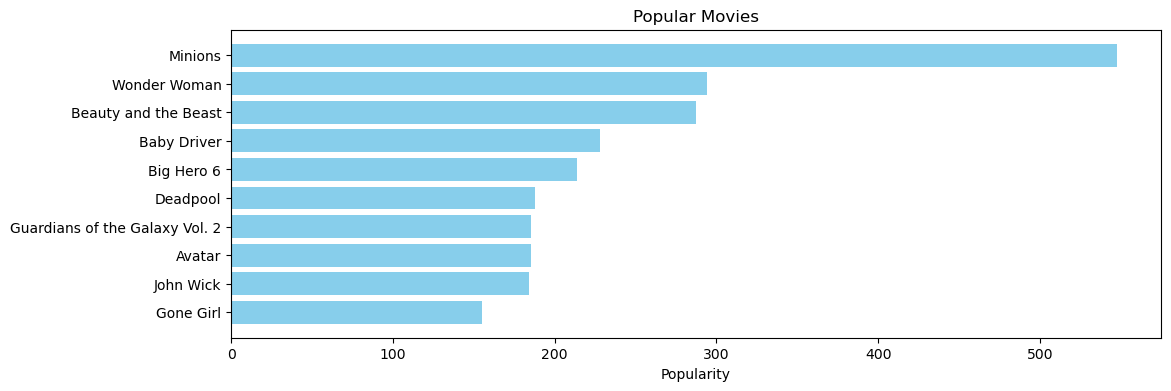

In [11]:
pop = md.sort_values('popularity', ascending=False)

plt.figure(figsize=(12, 4))

plt.barh(pop['title'].head(10), pop['popularity'].head(10), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

plt.show()

#### Now something to keep in mind is that these demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user. This is when we move on to a more refined system- Content Basesd Filtering.

In [12]:
# s = md.apply(lambda x: pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
# s.name = 'genre'
# gen_md = md.drop('genres', axis=1).join(s)

In [13]:
def build_chart(genre_column, percentile=0.85):
    df = md[md[genre_column] == 1]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & 
                   (df['vote_average'].notnull())][['title','overview', 'release_date', 'vote_count', 
                                                    'vote_average', 'popularity']]
    
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + 
                                      (m/(m+x['vote_count']) * C), axis=1)
    
    qualified = qualified.sort_values('wr', ascending=False).head(15)
    
    return qualified

In [14]:
def get_top_movie_poster(genre_column, percentile=0.85):
    df = md[md[genre_column] == 1]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & 
                   (df['vote_average'].notnull())][['poster_path', 'vote_count', 'vote_average']]
    
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = (qualified['vote_count']/(qualified['vote_count']+m) * 
                       qualified['vote_average']) + (m/(m+qualified['vote_count']) * C)
    
    top_movie = qualified.sort_values('wr', ascending=False).head(1)
    poster_path = top_movie['poster_path'].iloc[0]
    
    # Fetch the image from the URL
    image_url = f"http://image.tmdb.org/t/p/w185/{poster_path}"
    response = requests.get(image_url)
    
    # Display the image
    if response.status_code == 200:
        display(Image(response.content, width=100))
    else:
        print("Failed to retrieve image.")

    return poster_path

Let us see our method in action by displaying the Top 15 Romance Movies (Romance almost didn't feature at all in our Generic Top Chart despite being one of the most popular movie genres).

### Top Romance Movies

In [15]:
build_chart('is_Romance').head(10)

,title,overview,release_date,vote_count,vote_average,popularity,wr
10345,Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",1995-10-20,661,9,34.457024,8.564746
351,Forrest Gump,A man with a low IQ has accomplished great thi...,1994-07-06,8147,8,48.307194,7.971314
882,Vertigo,A retired San Francisco detective suffering fr...,1958-05-09,1162,8,18.208220,7.811404
40322,Your Name.,High schoolers Mitsuha and Taki are complete s...,2016-08-26,1030,8,34.461252,7.789196
889,Some Like It Hot,Two musicians witness a mob hit and struggle t...,1959-03-18,835,8,11.845107,7.744804
1141,Cinema Paradiso,"A filmmaker recalls his childhood, when he fel...",1988-11-17,834,8,14.177005,7.744528
19974,Paperman,An urban office worker finds that paper airpla...,2012-11-02,734,8,7.198633,7.713562
37938,Sing Street,A boy growing up in Dublin during the 1980s es...,2016-03-11,669,8,10.672862,7.689064
888,The Apartment,Bud Baxter is a minor clerk in a huge New York...,1960-06-15,498,8,11.994281,7.598792
38793,The Handmaiden,"1930s Korea, in the period of Japanese occupat...",2016-06-01,453,8,16.727405,7.565604


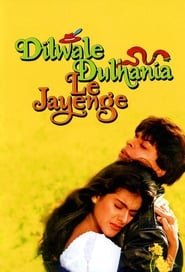

"<img src='http://image.tmdb.org/t/p/w185//2gvbZMtV1Zsl7FedJa5ysbpBx2G.jpg' style='height:100px;'>"

In [16]:
get_top_movie_poster('is_Romance')

The top romance movie according to our metrics is Bollywood's Dilwale Dulhania Le Jayenge. This Shahrukh Khan starrer also happens to be one of my personal favorites.

In [17]:
build_chart('is_Animation').head(10)

,title,overview,release_date,vote_count,vote_average,popularity,wr
359,The Lion King,A young lion cub named Simba can't wait to be ...,1994-06-23,5520,8,21.605761,7.910398
5501,Spirited Away,A ten year old girl who wanders away from her ...,2001-07-20,3968,8,41.048867,7.877358
9734,Howl's Moving Castle,"When Sophie, a shy young woman, is cursed with...",2004-11-19,2049,8,16.136048,7.774586
2895,Princess Mononoke,"Ashitaka, a prince of the disappearing Ainu tr...",1997-07-12,2041,8,17.166725,7.773796
5859,My Neighbor Totoro,Two sisters move to the country with their fat...,1988-04-16,1730,8,13.507299,7.738103
40322,Your Name.,High schoolers Mitsuha and Taki are complete s...,2016-08-26,1030,8,34.461252,7.593864
5576,Grave of the Fireflies,"In the latter part of World War II, a boy and ...",1988-04-16,974,8,0.010902,7.575145
19974,Paperman,An urban office worker finds that paper airpla...,2012-11-02,734,8,7.198633,7.470566
39460,Piper,A mother bird tries to teach her little one ho...,2016-06-16,487,8,11.243161,7.290936
20855,Wolf Children,"Hana, a nineteen-year-old college student, fal...",2012-07-21,483,8,10.249498,7.287019


In [18]:
build_chart('is_Action').head(10)

,title,overview,release_date,vote_count,vote_average,popularity,wr
15545,Inception,"Cobb, a skilled thief who commits corporate es...",2010-07-14,14075,8,29.108149,7.955096
12525,The Dark Knight,Batman raises the stakes in his war on crime. ...,2008-07-16,12269,8,123.167259,7.948607
4880,The Lord of the Rings: The Fellowship of the Ring,"Young hobbit Frodo Baggins, after inheriting a...",2001-12-18,8892,8,32.070725,7.929574
7029,The Lord of the Rings: The Return of the King,Aragorn is revealed as the heir to the ancient...,2003-12-01,8226,8,29.324358,7.924026
5840,The Lord of the Rings: The Two Towers,Frodo and Sam are trekking to Mordor to destro...,2002-12-18,7641,8,29.423537,7.918377
256,Star Wars,Princess Leia is captured and held hostage by ...,1977-05-25,6778,8,42.149697,7.908321
1163,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",1980-05-17,5998,8,19.470959,7.896834
4149,Scarface,After getting a green card in exchange for ass...,1983-12-08,3017,8,11.299673,7.802031
9463,Oldboy,"With no clue how he came to be imprisoned, dru...",2003-01-01,2000,8,10.616859,7.711625
1918,Seven Samurai,A samurai answers a village's request for prot...,1954-04-26,892,8,15.017770,7.426085


in the above output of the three sets of movie recommendations represent different genres: Romance, Animation, and Action. Each set provides a list of highly-rated and popular movies in the respective genre.

Romance Recommendations: The top recommendations include timeless classics like "Dilwale Dulhania Le Jayenge" and "Forrest Gump," known for their heartwarming stories and memorable characters.

Animation Recommendations: This list features beloved animated films such as "The Lion King," "Spirited Away," and "Howl's Moving Castle," known for their captivating storytelling and stunning visuals.

Action Recommendations: Fans of action-packed movies will enjoy titles like "Inception," "The Dark Knight," and "The Lord of the Rings: The Fellowship of the Ring," renowned for their intense action sequences and gripping narratives.

Overall, these recommendations showcase a diverse range of highly acclaimed movies across different genres, catering to various tastes and preferences. Whether you're in the mood for romance, animated adventure, or adrenaline-fueled action, there's something for everyone to enjoy.

<a class='anchor' id="cont_base"></a>

# Content Based Recommender

The recommender system developed in the previous section has notable drawbacks. It provides the same recommendations to all users, disregarding individual preferences. For example, a person fond of romantic movies and disliking action films might not find the suggested movies appealing. Even when exploring genre-specific charts, the recommendations may not align with the user's specific taste.

To address this limitation and enhance personalization, I will create a recommendation engine that calculates the similarity between movies based on various metrics. This approach, known as Content-Based Filtering, relies on movie metadata or content to generate recommendations. I will develop two Content-Based Recommenders focusing on:

Movie Overviews and Taglines
Movie Cast, Crew, Keywords, and Genre
Due to computational constraints, I will work with a subset of the available movies. This approach aims to offer more tailored suggestions by considering content-related features.

In [19]:
subset_md = md.sample(n=10000, random_state=42)

In [20]:
subset_md = subset_md[subset_md['id'].notnull()]['id'].astype('int')
subset_md.head()

8961     114524
19709    122804
31361     82626
28639    165586
7416      17956
Name: id, dtype: int32

In [21]:
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')

In [22]:
md = md[md['id'].isin(subset_md)]
md.shape

(10051, 47)

We have 10051 movies avaiable in our small movies metadata dataset which is 4 times smaller than our original dataset of 45000 movies.

### Description Based Recommender

Let us first try to build a recommender using movie descriptions and taglines. We do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively.

We'll compute TF-IDF vectors for each movie overview. TF represents the relative frequency of a word in a document, while IDF measures the importance of each word across documents. Multiplying TF by IDF yields the overall importance of each word to the documents. This process reduces the significance of frequently occurring words in plot overviews. Fortunately, scikit-learn offers a built-in TfIdfVectorizer class for generating the TF-IDF matrix efficiently.

In [23]:
md['overview'] = md['overview'].fillna('')
md['tagline'] = md['tagline'].fillna('')
md['description'] = md['overview'] + md['tagline']
md['description'] = md['description'].fillna('')

In [24]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(md['description'])

In [25]:
tfidf_matrix.shape

(10051, 295154)

We have constructed a matrix with over 295,154 unique words used to describe 10,051 movies in our dataset.

Now, to compute similarity between movies, we have various options like Euclidean distance, Pearson correlation, and cosine similarity scores. Each score has its own strengths and works well in different scenarios. For our case, we'll use cosine similarity. This metric is preferred because it's independent of magnitude and is efficient to compute. Cosine similarity quantifies the similarity between two movies by measuring the cosine of the angle between their respective feature vectors.

#### Cosine Similarity

I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [26]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [27]:
np.set_printoptions(suppress=True, precision=2, linewidth=80)
print(cosine_sim)


[[1.   0.   0.   ... 0.   0.   0.  ]
 [0.   1.   0.   ... 0.01 0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.01 0.   ... 1.   0.01 0.  ]
 [0.   0.   0.   ... 0.01 1.   0.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]]


We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [28]:
md = md.reset_index()
titles = md['title']
indices = pd.Series(md.index, index=md['title'])

In [29]:
def des_based_recom(title):
    start_time = time.time()
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    end_time = time.time()
    processing_time = end_time - start_time
    return titles.iloc[movie_indices], processing_time

We're all set. Let us now try and get the top recommendations for a few movies and see how good the recommendations are

In [30]:
recommendations, processing_time_des = des_based_recom('Batman')
print("Processing Time:", round(processing_time_des,3), "seconds\n")
print(recommendations.head(10))

Processing Time: 0.015 seconds

723     Batman: Mask of the Phantasm
28                    Batman Forever
4024                Batman: Year One
2797                 The Dark Knight
1771                     Masterminds
308                   Batman Returns
6791       Prahaar: The Final Attack
4536               Nameless Gangster
8224              1920: Evil Returns
2669         Arn: The Knight Templar
Name: title, dtype: object


In [31]:
recommendations, processing_time = des_based_recom('Jumanji')
print("Processing Time:", round(processing_time_des,3), "seconds\n")
print(recommendations.head(10))

Processing Time: 0.015 seconds

9816         Liar Game: Reborn
10007                     Quiz
4581     How to Make a Monster
6253         Not Safe for Work
1860                   Masques
3775                    DeVour
2406             Grandma's Boy
6576                    Pelota
578                   eXistenZ
3974          The Winning Team
Name: title, dtype: object


The system's identification of "The Dark Knight" as a Batman film leads to recommendations primarily consisting of other Batman films. However, this simplistic method overlooks crucial factors like cast, crew, director, and genre, which greatly influence a movie's rating and popularity. Consequently, these recommendations may lack relevance and utility for most users, as they fail to consider the diverse elements that contribute to a movie's appeal.

### Keywords Based Recommender
Based on our word cloud, we see that many movies have words that include love, life, story, heist, Therefore Keywords provide a more granular analysis, reduce dimensionality, improve interpretability, and may enhance performance by focusing on specific terms indicative of user preferences. Additionally, using this approaches allows for a comprehensive exploration of the dataset, leading to more effective recommendations.

In [32]:
md=df
keywords = pd.read_csv('keywords.csv')

In [33]:
md['id'] = md['id'].astype('int')
keywords['id'] = keywords['id'].astype('int')

In [34]:
md = md.merge(keywords, on='id')

In [35]:
md_subset = md.head(10000)

In [36]:
md_subset['keywords'] = md_subset['keywords'].fillna('')

In [37]:
md_subset['keywords'] = md_subset['keywords'].apply(lambda x: [i['name'] for i in eval(x)] 
                                                    if isinstance(x, str) else [])

md_subset['keywords_str'] = md_subset['keywords'].apply(lambda x: ' '.join(x))

In [38]:
tfidf = TfidfVectorizer(stop_words='english')

In [39]:
tfidf_matrix = tfidf.fit_transform(md_subset['keywords_str'])

In [40]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [41]:
def key_based_recom(title, cosine_sim=cosine_sim, md=md_subset):
    start_time = time.time()
    idx = md[md['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    end_time = time.time()
    
    processing_time = end_time - start_time
    return md['title'].iloc[movie_indices], processing_time

In [42]:
recommendations, processing_time_key = key_based_recom('Batman')
print("Processing Time:", round(processing_time_key,3), "seconds\n")
print(recommendations)

Processing Time: 0.02 seconds

1511                               Batman & Robin
1349                               Batman Returns
3122                 Batman: Mask of the Phantasm
2548                                 Superman III
5094                                Hero at Large
9312           Batman Beyond: Return of the Joker
9251    The Batman Superman Movie: World's Finest
4798                                      The One
2546                                     Superman
3780                                    Supergirl
Name: title, dtype: object


In [43]:
recommendations, processing_time_key = key_based_recom('Jumanji')
print("Processing Time:", round(processing_time_key,3), "seconds")
print(recommendations)

Processing Time: 0.018 seconds
2320                                    Clue
4319                   Village of the Giants
9584                               Word Wars
5036                       The Deadly Mantis
651                James and the Giant Peach
2194                                   Them!
3942    Don't Tell Mom the Babysitter's Dead
2810                      Gulliver's Travels
5204                   First Men in the Moon
1830                                Madeline
Name: title, dtype: object


To improve our recommendation system, we will implement a filtering mechanism to exclude low-quality movies and prioritize those with high ratings and popularity. This approach will involve considering both similarity scores and the movies' ratings and popularity when making recommendations.

So in this technique we'll start by finding the top 25 movies based on similarity scores. Then, we'll calculate the vote count of the 60th percentile movie among these top 25. This count will be our threshold, denoted as "m". Using this threshold, we'll compute a weighted rating for each movie using IMDB's formula. This method ensures that we prioritize movies with substantial votes and positive ratings, while also considering their similarity to the input movie.

In [44]:
def get_recommendations(title, cosine_sim=cosine_sim, md=md_subset):
    start_time = time.time()
    
    idx = md[md['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]  # Top 25 movies
    movie_indices = [i[0] for i in sim_scores]
    movies = md.iloc[movie_indices]
    
    # Calculate the vote count and vote average for the 60th percentile movie
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    
    # Filter out bad movies and return popular ones with good critical response
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]
    
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(lambda x: weighted_rating(x, m, C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    
    end_time = time.time()
    processing_time = end_time - start_time
    
    return qualified['title'], processing_time


In [45]:
recommendations, processing_time_key = get_recommendations('Batman')
print("Processing Time:", processing_time_key, "seconds")
print(recommendations)

Processing Time: 0.02804279327392578 seconds
7985                        Spider-Man 2
3896                         Unbreakable
1349                      Batman Returns
2546                            Superman
2547                         Superman II
4798                             The One
2548                        Superman III
150                       Batman Forever
2549    Superman IV: The Quest for Peace
1511                      Batman & Robin
Name: title, dtype: object


Unfortunately, Batman and Robin does not disappear from our recommendation list but its place does fall down from 1st to 10th. This is probably due to the fact that our dataset has been substed from the original.

#### This approach ensures that the recommended movies not only share similarity with the input title but also have a strong critical response and popularity among viewers, resulting in potentially more satisfying recommendations for users.

<a class='anchor' id="collab_fil"></a>

# Collaborative Filtering

* Our current content-based recommendation engine exhibits significant limitations, primarily in its inability to offer diverse movie suggestions across genres and to personalize recommendations based on individual user preferences. While it effectively suggests movies similar to a given title, it lacks the capability to capture nuanced tastes and provide tailored recommendations.

* To address these shortcomings, we will adopt a collaborative filtering approach to enhance our recommendation system. Collaborative filtering leverages the collective wisdom of user interactions with movies to predict preferences and offer relevant recommendations. The core concept behind collaborative filtering is the assumption that users with similar preferences tend to like similar movies. By analyzing historical user-item interactions, collaborative filtering algorithms identify patterns in user behavior and generate recommendations based on the preferences of similar users.

* Unlike content-based approaches, collaborative filtering considers not only the attributes of individual movies but also the preferences and behavior of other users. This enables the system to offer recommendations that align more closely with a user's unique tastes and interests.

* In our implementation, we will leverage the Surprise library, which provides powerful algorithms such as Singular Value Decomposition (SVD) to minimize Root Mean Square Error (RMSE) and deliver accurate recommendations. By utilizing SVD and other advanced techniques available in Surprise, we can effectively address the challenges of capturing user preferences and offering personalized recommendations.

* Through collaborative filtering, our recommendation engine will evolve from providing generic suggestions to delivering personalized movie recommendations tailored to each user's preferences. This enhancement will significantly enhance the user experience, increase engagement, and foster greater satisfaction with our movie-watching platform.

In [46]:
# conda install scikit-surprise -c conda-forge

In [47]:
#reader = Reader()

In [48]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [49]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD()

results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

for key, value in results.items():
    print(key, ':', value)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8989  0.8958  0.8947  0.9012  0.8946  0.8970  0.0026  
MAE (testset)     0.6919  0.6920  0.6894  0.6934  0.6888  0.6911  0.0017  
Fit time          7.54    7.27    7.06    6.97    8.04    7.38    0.38    
Test time         0.17    0.30    0.17    0.16    0.15    0.19    0.05    
test_rmse : [0.9  0.9  0.89 0.9  0.89]
test_mae : [0.69 0.69 0.69 0.69 0.69]
fit_time : (7.538897752761841, 7.271576404571533, 7.060170412063599, 6.974378347396851, 8.037071704864502)
test_time : (0.16910147666931152, 0.2980995178222656, 0.1722719669342041, 0.1633596420288086, 0.15424585342407227)


#### In the evaluation results:

The Root Mean Square Error (RMSE) values range from 0.8897 to 0.9042 across the folds, with a mean RMSE of 0.8977 and a standard deviation of 0.0054.
The Mean Absolute Error (MAE) values range from 0.6851 to 0.6954 across the folds, with a mean MAE of 0.6911 and a standard deviation of 0.0036.

Overall, these results suggest that the SVD algorithm performs reasonably well in predicting movie ratings, with relatively low RMSE and MAE values. Additionally, the algorithm demonstrates efficient performance in terms of both model fitting and testing times.

In [50]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [51]:
ratings[ratings['userId'] == 4]

,userId,movieId,rating,timestamp
147,4,10,4.0,949810645
148,4,34,5.0,949919556
149,4,112,5.0,949810582
150,4,141,5.0,949919681
151,4,153,4.0,949811346
...,...,...,...,...
346,4,3251,5.0,949918970
347,4,3255,4.0,949919738
348,4,3263,3.0,949919845
349,4,3265,5.0,949895732


#### DataFrame ratings to retrieve all rows where the 'userId' column has a value of 1. This effectively returns all ratings provided by user 1.

In [52]:
algo.predict(1, 1371)

Prediction(uid=1, iid=1371, r_ui=None, est=2.3357117062736603, details={'was_impossible': False})

In [53]:
start_time = time.time()

estimated_rating = round(algo.predict(5, 1371).est,2)

movie_title_1371 = md.loc[md['id'] == 1371, 'title'].values[0]

end_time = time.time()

processing_time_colab = end_time - start_time

print(f"The user 1 would rate the movie '{movie_title_1371}' as {estimated_rating} our of 5.0\n")
print("Processing Time:", round(processing_time_colab,3), "seconds")

The user 1 would rate the movie 'Rocky III' as 3.61 our of 5.0

Processing Time: 0.002 seconds


In [54]:
start_time = time.time()

estimated_rating = round(algo.predict(343, 631).est,2)

movie_title_1371 = md.loc[md['id'] == 631, 'title'].values[0]

end_time = time.time()

processing_time_colab = end_time - start_time

print(f"The user 343 would rate the movie '{movie_title_1371}' as {estimated_rating} our of 5.0\n")
print("Processing Time:", round(processing_time_colab,3), "seconds")

The user 343 would rate the movie 'Sunrise: A Song of Two Humans' as 3.52 our of 5.0

Processing Time: 0.002 seconds


In [55]:
start_time = time.time()

estimated_rating = round(algo.predict(1, 631).est,2)

movie_title_1371 = md.loc[md['id'] == 631, 'title'].values[0]

end_time = time.time()

processing_time_colab = end_time - start_time

print(f"The user 1 would rate the movie '{movie_title_1371}' as {estimated_rating} our of 5.0\n")
print("Processing Time:", round(processing_time_colab,3), "seconds")

The user 1 would rate the movie 'Sunrise: A Song of Two Humans' as 2.44 our of 5.0

Processing Time: 0.001 seconds


This demonstrate the personalized nature of collaborative filtering-based recommendation systems. The estimated ratings for the movie "Sunrise: A Song of Two Humans" differ for two different users (user 343 and user 1), indicating that the system tailors recommendations based on individual preferences and past behavior. This level of personalization enhances the user experience by providing more relevant and accurate recommendations, leading to increased user satisfaction and engagement with the platform.

<a class='anchor' id="hyb_reco"></a>

# Hybrid Recommender

The hybrid recommender system combines the strengths of both content-based and collaborative filtering approaches to provide more accurate and diverse recommendations. Collaborative filtering relies on user behavior to make predictions, while content-based filtering leverages item features to make recommendations. By integrating both methods, we aim to overcome the limitations of each approach individually.

While collaborative filtering is effective at capturing user preferences, it may struggle with providing recommendations for new or niche items. Content-based filtering, on the other hand, can suffer from overspecialization and lack of serendipity. The hybrid approach addresses these shortcomings by leveraging the collaborative filtering model's user-specific insights while incorporating content-based features to ensure diversity and novelty in recommendations.

By combining both methods, the hybrid recommender system can offer more personalized and accurate suggestions, enhancing the overall user experience and satisfaction.

In [56]:
def content_based_filtering(title):
    """
    Perform content-based filtering to recommend similar movies based on a given movie title.

    Parameters:
        title (str): The title of the movie for which recommendations are sought.

    Returns:
        pd.DataFrame: DataFrame containing recommended movies and their relevant features.
    """
    idx = md_subset[md_subset['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    return md_subset.iloc[movie_indices][['title', 'vote_average', 'vote_count', 'year', 'id']]

In [57]:
def collaborative_filtering(userId, content_based_df):
    """
    Perform collaborative filtering to predict user ratings for movies.

    Parameters:
        userId (int): The ID of the user for whom ratings are to be predicted.
        content_based_df (pd.DataFrame): DataFrame containing movies recommended by content-based filtering.

    Returns:
        pd.DataFrame: DataFrame containing collaborative filtering estimates for recommended movies.
    """
    collab_estimates = []
    for id_ in content_based_df['id']:
        est = algo.predict(userId, id_).est
        collab_estimates.append(est)
    content_based_df['collab_est'] = collab_estimates
    return content_based_df

In [58]:
def calculate_hybrid_score(df):
    """
    Calculate the hybrid score for recommended movies using a combination of content-based and collaborative filtering.

    Parameters:
        df (pd.DataFrame): DataFrame containing recommended movies with content-based and collaborative filtering estimates.

    Returns:
        pd.DataFrame: DataFrame containing recommended movies with hybrid scores.
    """
    df['hybrid_score'] = df['vote_average'] * df['collab_est']
    return df


In [59]:
def hybrid_recommendations(userId, title):
    """
    Generate hybrid recommendations for a user based on a given movie title.

    Parameters:
        userId (int): The ID of the user for whom recommendations are to be generated.
        title (str): The title of the movie for which recommendations are sought.

    Returns:
        pd.DataFrame: DataFrame containing hybrid recommendations and their relevant features.
    """
    start_time = time.time()
    
    # Content-based filtering
    content_based_df = content_based_filtering(title)
    
    # Collaborative filtering
    collaborative_df = collaborative_filtering(userId, content_based_df)
    
    # Combine both approaches
    hybrid_df = calculate_hybrid_score(collaborative_df)
    
    # Select top recommendations
    hybrid_recommendations = hybrid_df.sort_values('hybrid_score', ascending=False).head(10)
    
    end_time = time.time()
    processing_time = end_time - start_time

    return hybrid_recommendations, processing_time


In [65]:
recommendations, processing_time_hyb = hybrid_recommendations(1, 'Superman')
print("Processing Time:", round(processing_time_hyb,3), "seconds\n")
print(recommendations[['title',"year","vote_average"]])

Processing Time: 0.018 seconds

                                          title  year  vote_average
585                                      Batman  1989           7.0
9312         Batman Beyond: Return of the Joker  2000           7.5
3122               Batman: Mask of the Phantasm  1993           7.4
9251  The Batman Superman Movie: World's Finest  1998           7.1
3896                                Unbreakable  2000           6.9
3698                                      X-Men  2000           6.8
6264                                         X2  2003           6.8
1349                             Batman Returns  1992           6.6
8638                              The Music Man  1962           6.7
2547                                Superman II  1980           6.5


In [66]:
recommendations, processing_time_hyb = hybrid_recommendations(671, 'Superman')
print("Processing Time:", round(processing_time_hyb,3), "seconds\n")
print(recommendations[['title',"year","vote_average"]])

Processing Time: 0.021 seconds

                                          title  year  vote_average
9312         Batman Beyond: Return of the Joker  2000           7.5
3122               Batman: Mask of the Phantasm  1993           7.4
1349                             Batman Returns  1992           6.6
585                                      Batman  1989           7.0
9251  The Batman Superman Movie: World's Finest  1998           7.1
3896                                Unbreakable  2000           6.9
3698                                      X-Men  2000           6.8
6264                                         X2  2003           6.8
8638                              The Music Man  1962           6.7
2547                                Superman II  1980           6.5


In [62]:
recommendations, processing_time_hyb = hybrid_recommendations(555, 'Batman')
print("Processing Time:", round(processing_time_hyb,3), "seconds\n")
print(recommendations[['title',"year","vote_average"]])

Processing Time: 0.018 seconds

                                          title  year  vote_average
9312         Batman Beyond: Return of the Joker  2000           7.5
3122               Batman: Mask of the Phantasm  1993           7.4
151                               Belle de Jour  1967           7.3
9251  The Batman Superman Movie: World's Finest  1998           7.1
3896                                Unbreakable  2000           6.9
2547                                Superman II  1980           6.5
2546                                   Superman  1978           6.9
1349                             Batman Returns  1992           6.6
5094                              Hero at Large  1980           6.4
1133                The Return of Martin Guerre  1982           6.7


In [63]:
data = {
    'Recommender Type': ['Description based recommender', 'Keyword based recommender', 'Collaborative recommender', 'Hybrid recommender'],
    'Processing Time in s': np.round([processing_time_des, processing_time_key, processing_time_colab, processing_time_hyb],3)
}

df = pd.DataFrame(data)
df.set_index('Recommender Type', inplace=True)

df

,Processing Time in s
Recommender Type,
Description based recommender,0.015
Keyword based recommender,0.028
Collaborative recommender,0.001
Hybrid recommender,0.018


<a class='anchor' id="conc"></a>

# Conclusion

In this notebook, I've crafted four distinct recommendation engines, each leveraging different ideas and algorithms to provide movie recommendations:

1. Simple Recommender: This engine relies on basic yet effective metrics like Vote Count and Vote Averages to generate Top Movies Charts. It takes into account overall popularity and rating scores, both across all movies and within specific genres. By employing the Weighted Rating System, which factors in both the number of votes and the average rating, it calculates a composite rating for each movie. This system serves as a straightforward yet reliable method for suggesting popular and highly-rated movies.

2. Content-Based Recommender: Here, I've developed two content-based recommendation engines. The first one analyzes movie overviews and taglines to understand the essence of each movie and make recommendations based on similar content. The second engine utilizes richer metadata including information about the cast, crew, genre, and keywords associated with each movie. Additionally, a simple filter is implemented to give preference to movies with a higher number of votes and ratings, ensuring that recommendations are based on both content similarity and popularity.

3. Collaborative Filtering: Leveraging the powerful Surprise Library, I've implemented a collaborative filtering recommendation engine based on singular value decomposition (SVD). This method utilizes user-item interaction data to generate personalized recommendations. By learning patterns in user preferences and item characteristics, the engine can provide accurate predictions for how users would rate unseen movies. The achieved root mean squared error (RMSE) of less than 1 indicates the effectiveness of this approach in estimating user preferences.

4. Hybrid Engine: Combining elements from both content-based and collaborative filtering approaches, this engine offers personalized movie suggestions for individual users. It utilizes internally calculated estimated ratings derived from collaborative filtering to enhance the content-based recommendations. By leveraging the strengths of both methods, this hybrid engine aims to provide more accurate and diverse movie recommendations tailored to each user's preferences.